Exerimenting with Brian2 to produce bistable CPG networks.

# Imports

In [3]:
%matplotlib inline

import cma
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from __future__ import division

from brian2 import *
from itertools import *

ImportError: No module named brian2

# Styles

In [3]:
sns.set()
sns.set_style("white", rc={
    'axes.grid': False,
    'axes.labelcolor': '0.4',
    'axes.edgecolor': '0.8',
    'axes.facecolor': '1.0',
    'text.color': '0.4',
    'xtick.color': '0.4',
    'ytick.color': '0.4',
    'axes.linewidth': 2,
})
palette = sns.color_palette("Set2", 10)
sns.set_palette(palette)
sns.set_context("notebook", font_scale=1.2)

# Constants

In [4]:
tau = 2*ms
v_peak = 30.

# Neuron Model

In [5]:
eqs = '''
dv/dt = (.04 * (v**2) + 5. * v + 140. - u + I + DC) / tau : 1
du/dt = (a * (b * v - u)) / tau : 1
I : 1
DC : 1
a : 1 (constant)
b : 1 (constant)
c : 1 (constant)
d : 1 (constant)
'''

threshold = 'v > v_peak'

reset = '''
v = c
u += d
'''

reset_I = '''
I = 0.
'''

# Synapse Model

In [6]:
model = '''
w : 1
w_max : 1 (constant)
w_min : 1 (constant)
eta_pos : 1 (constant)
eta_neg : 1 (constant)
tau_pos : second (constant)
tau_neg : second (constant)
a_pos : 1 (constant)
a_neg : 1 (constant)
dx/dt = -x / tau_neg : 1 (event-driven) # pre-synaptic trace
dy/dt = -y / tau_pos : 1 (event-driven) # post-synaptic trace
'''

pre = '''
I_post += w * v_peak
y = a_pos
w = clip(w + (eta_neg * x), w_min, w_max)
'''

post='''
x = a_neg
w = clip(w + (eta_pos * y), w_min, w_max)
'''

# Simulation

## Plotting

In [31]:
def plot_monitors(MG, MS, MGS):
    figsize = (12, 4)
    offset = 10

    # plot V
    figure(figsize=figsize)
    for i, v in enumerate(MG.v):
        plot(MG.t/ms, v, label='V (%d)' % i, alpha=0.8)

    sns.despine(offset=offset, trim=True)
    title("V")
    legend(loc="best")
    
    # plot recovery
    figure(figsize=figsize)
    for i, u in enumerate(MG.u):
        plot(MG.t/ms, u, label='u (%d)' % i)

    sns.despine(offset=offset, trim=True)
    title("recovery")
    legend(loc="best")

    # plot spikes
    figure(figsize=figsize)
    plot(MGS.t/ms, MGS.i, '.')

    sns.despine(offset=offset, trim=True)
    title("Spikes")
    legend(loc="best")

    # plot input
    figure(figsize=figsize)
    for i, I in enumerate(MG.I):
        plot(MG.t/ms, I, label='I (%d)' % i)

    sns.despine(offset=offset, trim=True)
    title("I")
    legend(loc="best")

    # plot weight
    figure(figsize=figsize)
    for i, w in enumerate(MS.w):
        plot(MS.t/ms, w, label='w (%d)' % i)

    sns.despine(offset=offset, trim=True)
    title("w")
    legend(loc="best")

## Simple CPG

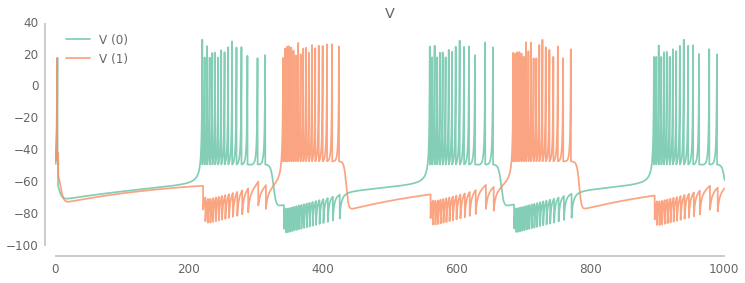

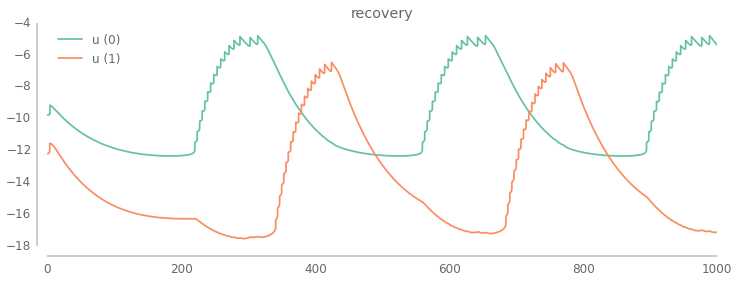

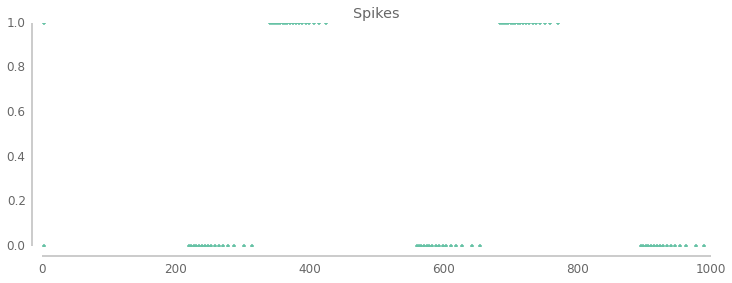

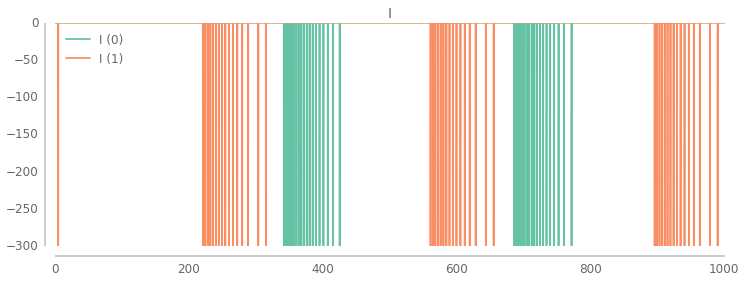

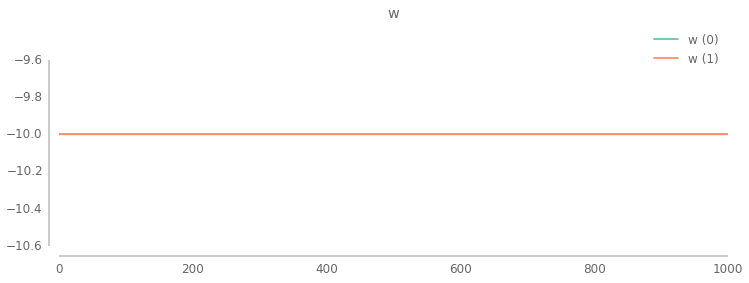

In [97]:
def simulate():
    duration = 1000*ms

    n = 2
    G = NeuronGroup(n, eqs, threshold=threshold, reset=reset)
    G.DC = [4., 0.]
    G.a = [.02, .02]
    G.b = [.2, .26]
    G.c = [-49., -47.]
    G.d = [.5, .5]
    G.v = 'c'
    G.u = 'b * v'

    I_reset = G.custom_operation(reset_I, when='thresholds')

    S = Synapses(G, model=model, pre=pre, post=post, delay=1*ms)
    S.connect('i==((j+1)%n)')
    S.w = -10.
    S.w_max = 10.
    S.w_min = -10.
    S.a_pos = 1.
    S.a_neg = 1.
    S.eta_pos = 0.
    S.eta_neg = -0.
    S.tau_pos = 20*ms
    S.tau_neg = 20*ms

    MG = StateMonitor(G, ('v', 'u', 'I'), record=True)
    MS = StateMonitor(S, ('w', 'x', 'y'), record=True)
    MGS = SpikeMonitor(G)

    N = Network(G, S, MG, MS, MGS, I_reset)
    N.run(duration)

    plot_monitors(MG, MS, MGS)
    
    return (list(MGS.i_), list(MGS.t))
    
spikes = simulate()

## Bi-CPG

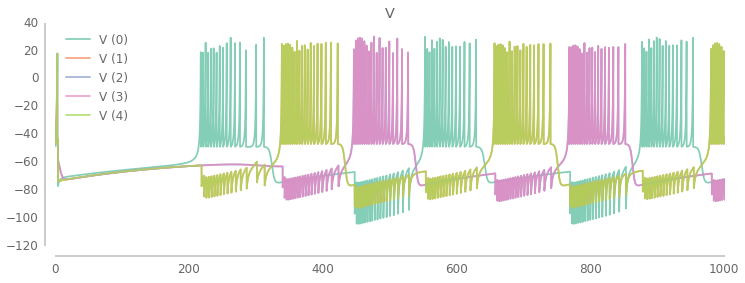

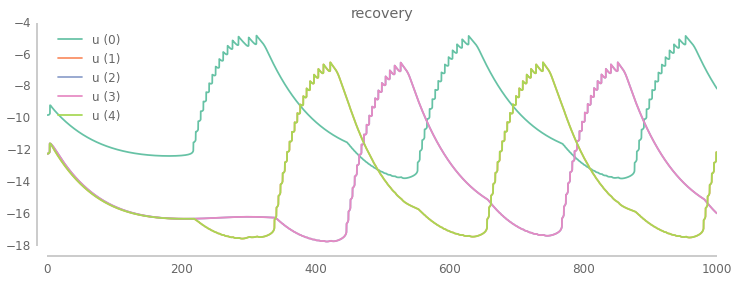

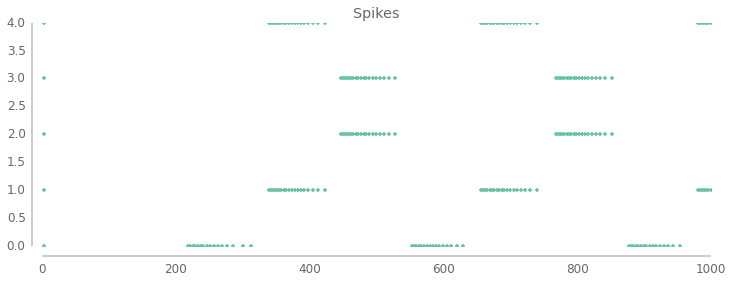

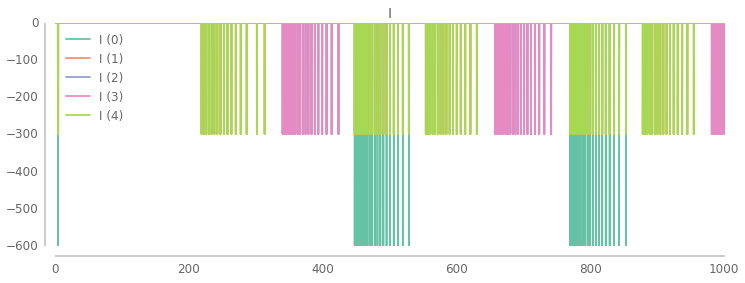

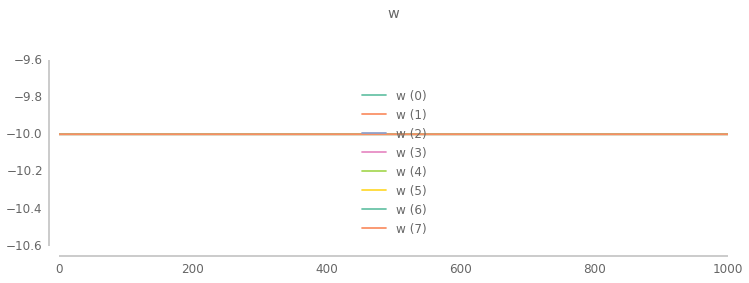

In [34]:
def simulate():
    duration = 1000*ms

    n = 5
    G = NeuronGroup(n, eqs, threshold=threshold, reset=reset)
    G.DC = [4., 0., 0., 0., 0.]
    G.a = [.02, .02, .02, .02, .02]
    G.b = [.2, .26, .26, .26, .26]
    G.c = [-49., -47., -47., -47., -47]
    G.d = [.5, .5, .5, .5, .5]
    G.v = 'c'
    G.u = 'b * v'

    I_reset = G.custom_operation(reset_I, when='thresholds')

    S = Synapses(G, model=model, pre=pre, post=post, delay=1*ms)

    S.connect([1, 2], [2, 1])
    S.connect([3, 4], [4, 3])
    S.connect([0, 2, 0, 3], [1, 0, 4, 0])

    S.w = -10.
    S.w_max = 10.
    S.w_min = -10.
    S.a_pos = 1.
    S.a_neg = 1.
    S.eta_pos = 0.
    S.eta_neg = -0.
    S.tau_pos = 20*ms
    S.tau_neg = 20*ms

    MG = StateMonitor(G, ('v', 'u', 'I'), record=True)
    MS = StateMonitor(S, ('w', 'x', 'y'), record=True)
    MGS = SpikeMonitor(G)

    N = Network(G, S, MG, MS, MGS, I_reset)
    N.run(duration)

    plot_monitors(MG, MS, MGS)
    
    return (list(MGS.i_), list(MGS.t))
    
spikes = simulate()

# Fitness Function

In [193]:
def get_spike_pairs(i_, t):
    d = defaultdict(list)
    for i, t in zip(i_, t):
        d[i].append(t)
    for i in d:
        d[i] = d[i]/ms
    return d

def get_bins(spikes, bin_size=50, offset=0):
    return [floor((spike - offset) / bin_size) for spike in spikes]

def get_bin_counts(bins):
    bin_counts = defaultdict(int)
    for b in bins:
        bin_counts[b] = bin_counts[b] + 1
    return bin_counts

def calculate_neuron_fitness(spikes):
    # TODO: calculate duty cycle: http://en.wikipedia.org/wiki/Duty_cycle — aim for 50% per neuron
    return 0.

def calculate_fitness(i_, t):
    spikes = get_spike_pairs(i_, t)
    a = calculate_neuron_fitness(spikes[0])
    b = calculate_neuron_fitness(spikes[1])
    diff = a - b
    return (a + b + diff) / 3.

# CMA

In [474]:
opts = cma.CMAOptions()
opts['scaling_of_variables'] = ([1, 1, 1e1, 1] * 2) + ([1, 1, 1, 1e1, 1e1] * 2)
opts['verb_disp'] = 1
opts

{'AdaptSigma': 'CMAAdaptSigmaCSA  # or any other CMAAdaptSigmaBase class e.g. CMAAdaptSigmaTPA',
 'CMA_active': 'True  # negative update, conducted after the original update',
 'CMA_cmean': '1  # learning rate for the mean value',
 'CMA_const_trace': 'False  # normalize trace, value CMA_const_trace=2 normalizes sum log eigenvalues to zero',
 'CMA_dampsvec_fac': 'np.Inf  # tentative and subject to changes, 0.5 would be a "default" damping for sigma vector update',
 'CMA_dampsvec_fade': '0.1  # tentative fading out parameter for sigma vector update',
 'CMA_diagonal': '0*100*N/sqrt(popsize)  # nb of iterations with diagonal covariance matrix, True for always',
 'CMA_eigenmethod': 'np.linalg.eigh  # 0=numpy-s eigh, -1=pygsl, otherwise cma.Misc.eig (slower)',
 'CMA_elitist': 'False  #v or "initial" or True, elitism likely impairs global search performance',
 'CMA_mirrormethod': '1  # 0=unconditional, 1=selective, 2==experimental',
 'CMA_mirrors': 'popsize < 6  # values <0.5 are interpreted 

In [ ]:
# a (-1-1), b (0-1), c (-100-0), d (-10-10)
# w (-1-1), eta, eta (-1-1), tau, tau (0-20)

x0 = '[2. * np.random.randn(), np.random.randn() + .5, 100. * np.random.randn() + -50., 20. * np.random.randn()] + [2. * np.random.randn(), np.random.randn() + .5, 100. * np.random.randn() + -50., 20. * np.random.randn()] + [2. * np.random.randn(), 2. * np.random.randn(), 2. * np.random.randn(), 20. * np.random.randn() + 10., 20. * np.random.randn() + 10.] + [2. * np.random.randn(), 2. * np.random.randn(), 2. * np.random.randn(), 20. * np.random.randn() + 10., 20. * np.random.randn() + 10.]'
sigma0 = 0.1

def objective_fn(x, *args):
    spikes = run_simulation(x, *args)
    return calculate_fitness(*spikes)

res = cma.fmin(objective_fn, x0, sigma0, args=(250.*ms,), restarts=2, bipop=True, options=opts)

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 18 (seed=524367, Thu Apr 30 14:13:47 2015)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 2.271347404977793e-01 1.0e+00 9.49e-02  9e-02  1e-01 1:31.6
    2     24 2.213048178729651e-01 1.1e+00 9.67e-02  9e-02  1e-01 2:59.8
    3     36 2.210036031212899e-01 1.2e+00 1.01e-01  1e-01  1e-01 4:26.9
  100   1200 1.955184220154642e-01 3.7e+00 2.46e+00  2e+00  4e+00 157:40.7
  200   2400 1.932913603904633e-01 1.5e+01 1.49e+00  2e-01  2e+00 305:10.1
  300   3600 1.918354635325566e-01 3.5e+01 7.96e-01  7e-02  1e+00 453:53.8
  400   4800 1.907169580083654e-01 3.7e+01 2.06e-01  2e-02  3e-01 603:51.4
  500   6000 1.905270292767214e-01 7.3e+01 1.43e-01  4e-03  2e-01 756:3.0


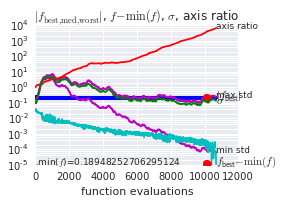

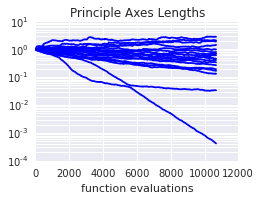

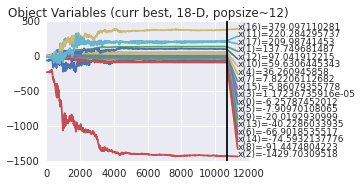

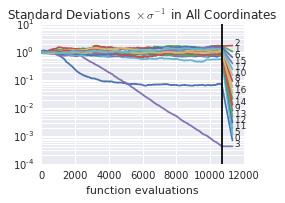

In [3]:
cma.plot()